In [ ]:
# default_exp analysis

# Analysis & Visualization

> Correlation analysis and visualization.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sully import eda

In [ ]:
data = eda.load('bird-strikes')

## Correlations, take 2

Earlier we tried to look into correlations, but failed because too many columns were categorial. We can cast those categories into `pd.Categorical` types and then access their automagically created numeric codes so that a numerical analysis, such as `pd.DataFrame.corr()`, will produce proper results.

In [ ]:
#export
def makeCatCodes(data:pd.DataFrame, columns:list)->pd.DataFrame:
    for col in columns:
        data[col] = pd.Categorical(data[col])

    codes = {}
    for col in columns:
        codes[col] = data[col].cat.codes
        
    return pd.DataFrame(codes)

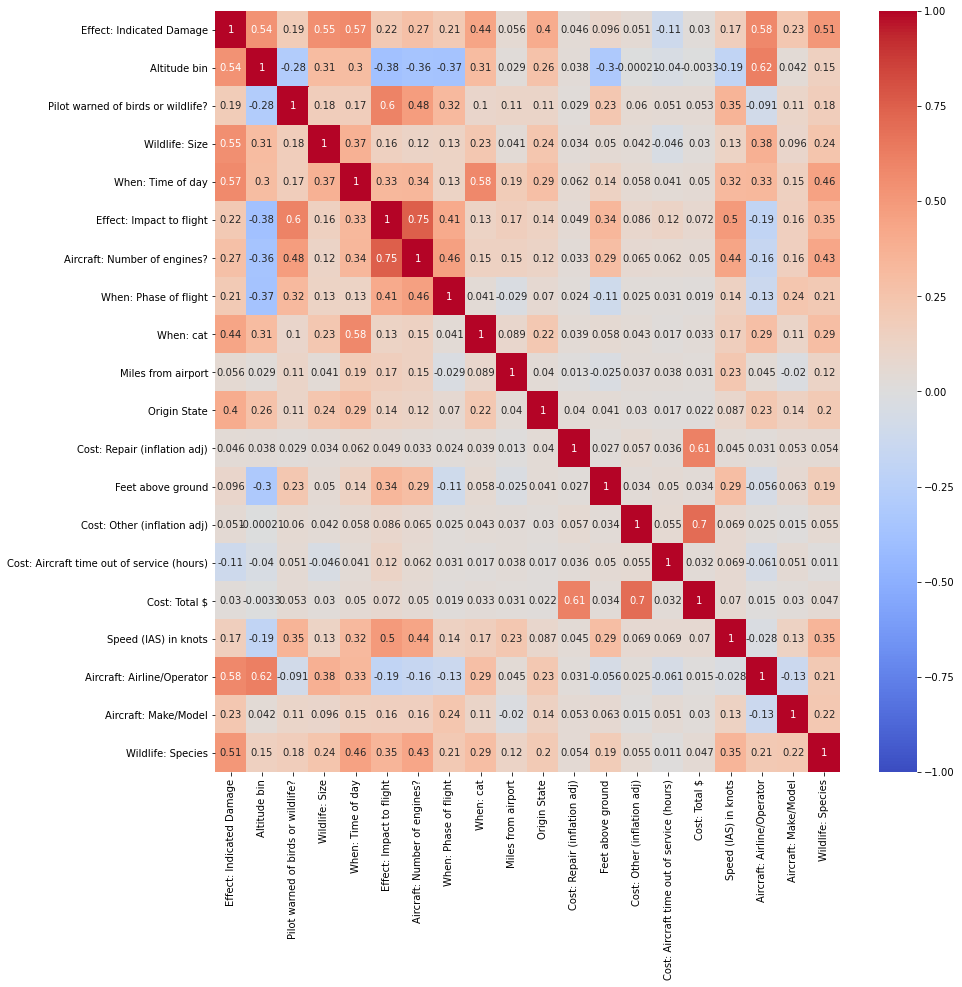

In [ ]:
data_cc = makeCatCodes(data.copy(), eda.findCategoricalCandidates(data)['name'])
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(data_cc.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax);

Several clusters can be identified directly:
* `{'Effect: Indicated Damage', 'Altitude bin', 'Wildlife: Size', 'When: Time of day'}²`
* `{'Aircraft: Airline/Operator', 'Aircraft: Make/Model', 'Wildlife: Species'} x {'Effect: Indicated Damage', 'Altitude bin', 'Wildlife: Size'}`
* `{'When: Time of day', 'Effect: Impact to flight', 'Aircraft: Number of engines?'}²`
* `{'When: Time of day', 'Effect: Impact to flight', 'Aircraft: Number of engines?'} x {'Speed (IAS) in knots', 'Aircraft: Make/Model', 'Wildlife: Species}`

`Effect: {Impact to flight, Indicated Damage}` are both related, yet one is missing data for nearly half the records, whereas the other is mostly complete. Instead of attempting to fix `Effect: Impact to flight` we will stick to `Effect: Indicated Damage`.

In [ ]:
data['Effect: Impact to flight'].isna().sum() / len(data), data['Effect: Indicated Damage'].isna().sum() / len(data)

(0.4969974089315653, 0.09128181679622009)

## Airport: Name &rarr; Effect: Indicated Damage

Notice that we use crosstables to get margins on each aggregated sub table. Margins show up as an additional `All` column. This simplifies sorting and makes for easier "top x"-style queries.

In [ ]:
data_ct = pd.crosstab([data['Airport: Name']], data['Effect: Indicated Damage'], margins=True)
data_ct.sort_values(by='All', ascending=False)[1:].head(5)

Effect: Indicated Damage,Caused damage,No damage,All
Airport: Name,,,
DENVER INTL AIRPORT,64,2287,2351
DALLAS/FORT WORTH INTL ARPT,47,1772,1819
MEMPHIS INTL,61,1173,1234
JOHN F KENNEDY INTL,80,1148,1228
CHICAGO O'HARE INTL ARPT,63,1061,1124


We limit our result to the first 20 records via dataframe slicing like so: `some_df[-21:-1]`. We skip the first record because in our reversely sorted dataframe, this would show the totals (margins) for each column

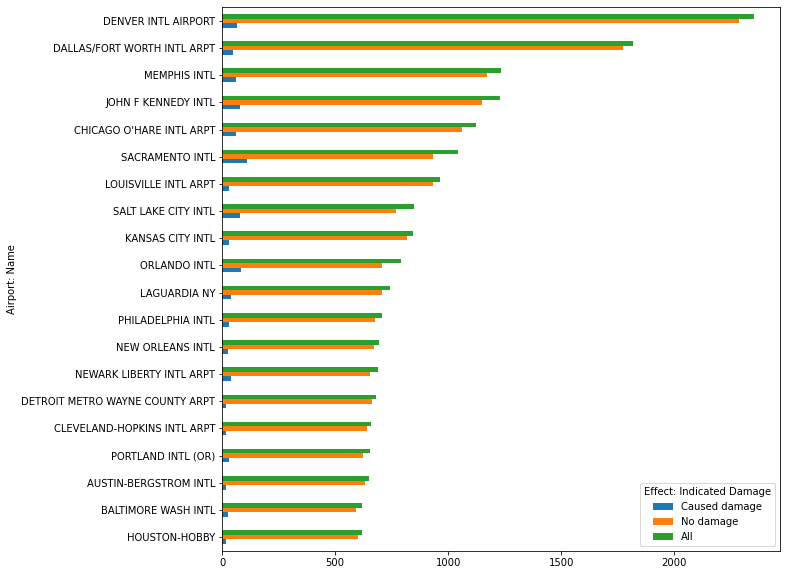

In [ ]:
data_ct.sort_values(by='All', ascending=True)[-21:-1].plot.barh(figsize=(10,10));

We can see that certain airports among the top 20, such as Denver INTL Airport or Dallas/Fort Worth INTL ARPT, report bird strikes at a much higher rate. A quick check reveals those airports to be near military (air) bases.

The majority of reported bird strikes cause no damage to the aircraft.

## Aircraft: Airline/Operator, Airport: Name &rarr; Effect: Indicated Damage

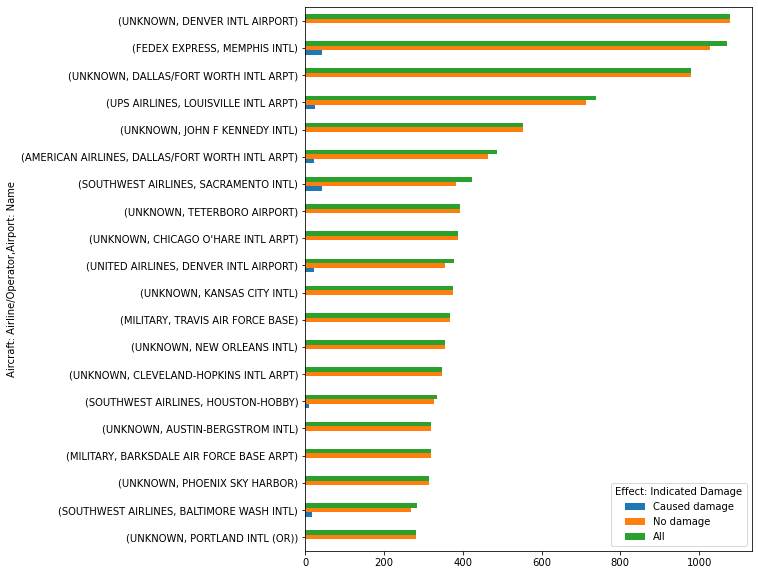

In [ ]:
data_op_ct = pd.crosstab([data['Aircraft: Airline/Operator'], data['Airport: Name']], data['Effect: Indicated Damage'], margins=True)
data_op_ct.sort_values(by='All', ascending=True)[-21:-1].plot.barh(figsize=(8,10));

Southwest Airlines shows up often, with Fedex Express at Memphis International taking the 2nd spot and UPS Airlines at Louisville INTL ARPT taking the 4th spot. Dallas/Fort Worth INTL ARPT and Denver INTL Airport are dominated by 'unknown'. The latter two are airfreight carriers, with Southwest Airlines running a [domestic airfreight branch](https://www.swacargo.com/). One can see that Fedex Express also claims the majority of bird strike reports at Memphis International (86.7%):

In [ ]:
data_op_ct.loc['FEDEX EXPRESS', 'MEMPHIS INTL']['All'] / data_ct.loc['MEMPHIS INTL']['All']

0.8679092382495948

UPS Airlines dominates bird strike reports at Louisville International Airport (76.4%):

In [ ]:
data_op_ct.loc['UPS AIRLINES', 'LOUISVILLE INTL ARPT']['All'] / data_ct.loc['LOUISVILLE INTL ARPT']['All']

0.7645228215767634

Let's check if we find other airports where bird strike reports are dominated by a single airline operator.

In [ ]:
operators = []
airports = []
ratios = []
totals = []
bounds = (.1, 1)
min_reports = 100

for idx in data_op_ct.index[:-1]:
    op = idx[0]
    ap = idx[1]
    
    t = data_ct.loc[ap]['All']
    r = data_op_ct.loc[idx]['All'] / max(1, t)

    if r >= bounds[0] and r < bounds[1] and t >= min_reports:
        operators.append(op)
        airports.append(ap)
        ratios.append(r)
        totals.append(t)

op_ap_r = pd.DataFrame({'operator': operators,
                        'airports': airports,
                        'ratio': ratios,
                        'totals': totals})

In [ ]:
op_ap_r.sort_values(by='ratio', ascending=False).head(10)

,operator,airports,ratio,totals
109,MILITARY,TRAVIS AIR FORCE BASE,0.997290,369
89,MILITARY,DOVER AIR FORCE BASE,0.994565,184
99,MILITARY,MC GUIRE AIR FORCE BASE,0.992095,253
84,MILITARY,ANDREWS AIR FORCE BASE,0.991228,114
111,MILITARY,WESTOVER ARB/METRO ARPT,0.990385,208
108,MILITARY,SHEPPARD AIR FORCE BASE,0.974359,195
100,MILITARY,MCCONNELL AIR FORCE BASE,0.971591,176
90,MILITARY,EGLIN AFB/NW FLORIDA REGIONAL ARPT,0.965753,146
104,MILITARY,NIAGARA FALLS INTL,0.876106,113
54,FEDEX EXPRESS,MEMPHIS INTL,0.867909,1234


Military bases obviously dominate bird strike reports at their respective airport, so let's filter them out.

In [ ]:
op_ap_r[op_ap_r['operator'] != 'MILITARY'].sort_values(by='ratio', ascending=False).head(10)

,operator,airports,ratio,totals
54,FEDEX EXPRESS,MEMPHIS INTL,0.867909,1234
205,UNKNOWN,GAINESVILLE REG ARPT,0.865385,104
190,UNKNOWN,CHARLES B WHEELER DOWNTOWN ARPT,0.834395,157
135,SOUTHWEST AIRLINES,DALLAS LOVE FIELD ARPT,0.826568,271
274,UNKNOWN,TWEED-NEW HAVEN ARPT,0.804878,123
0,ABX AIR,AIRBORNE AIRPARK,0.770370,135
282,UPS AIRLINES,LOUISVILLE INTL ARPT,0.764523,964
67,ISLAND AIR,KAPALUA ARPT,0.763158,114
188,UNKNOWN,BURKE LAKEFRONT,0.762215,307
275,UNKNOWN,VAN NUYS ARPT,0.723926,163


Memphis INTL and Louisville INTL ARPT look like air freight hubs (see operators). If air freight operations take mostly place at night, then their abnormal flight schedule could impose a higher risk of bird strikes, too.

## Air freight vs. other Aircraft: Airline/Operators

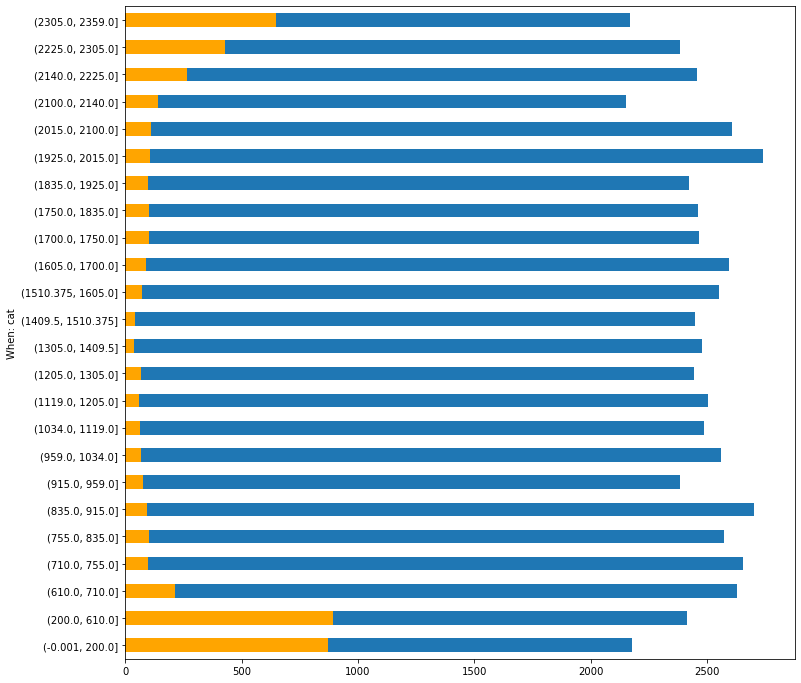

In [ ]:
airfreight_pred = data['Aircraft: Airline/Operator'].isin(['FEDEX EXPRESS', 'UPS AIRLINES'])
data.groupby('When: cat').count()['When: Time (HHMM)'].plot.barh(figsize=(12,12))
data[airfreight_pred].groupby('When: cat').count()['When: Time (HHMM)'].plot.barh(color='orange');

The time of day categories generated by `pd.qcut` are often close to one hour in range, apart from the late night/early hours categories. This indicates that flight schedules are mostly stable from noon to midnight (in terms of frequency).

We can assume that airfreight carriers mostly operate during night time, which is why for them the risk of bird strikes is naturally higher in those hours.

## Wildlife: Size, Altitude bin &rarr; Effect: Indicated Damage

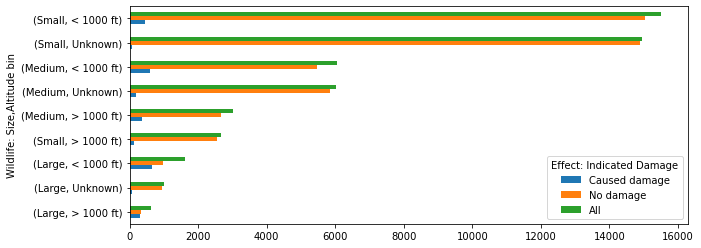

In [ ]:
pd.crosstab([data['Wildlife: Size'],
             data['Altitude bin']],
             data['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[:-1].plot.barh(figsize=(10, 4));

Bird strikes seem to happen with much higher frequency at lower altitudes. Smaller birds cause more reports! Large birds might be rarer, or perhaps it's the nature of smaller birds flying in large swarms.

## When: Time (HHMM) &rarr; Effect: Indicated Damage

Notice that we fold `When: Time (HHMM)` into hours for improved clarity. The column uses military time.

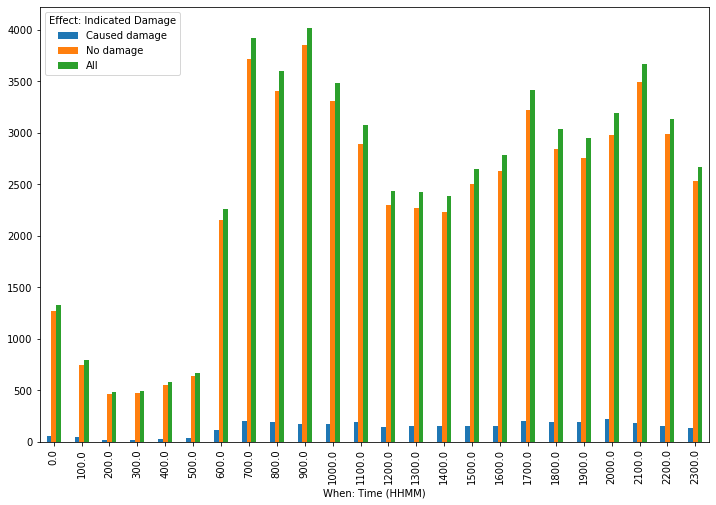

In [ ]:
pd.crosstab(data['When: Time (HHMM)'] // 100 * 100,
            data['Effect: Indicated Damage'],
            margins=True)[:-1].plot.bar(figsize=(12, 8));

We see a strong daily increase in bird strike reports beginning at 0600 til 1100, then a decline during noon/early afternoon (1200-1600) and again a rise in the evening/late night (1700-2300), followed by a sharp drop during night hours (0000-0500).

## When: Time of day, Aircraft: Number of engines? &rarr; Effect: Indicated Damage

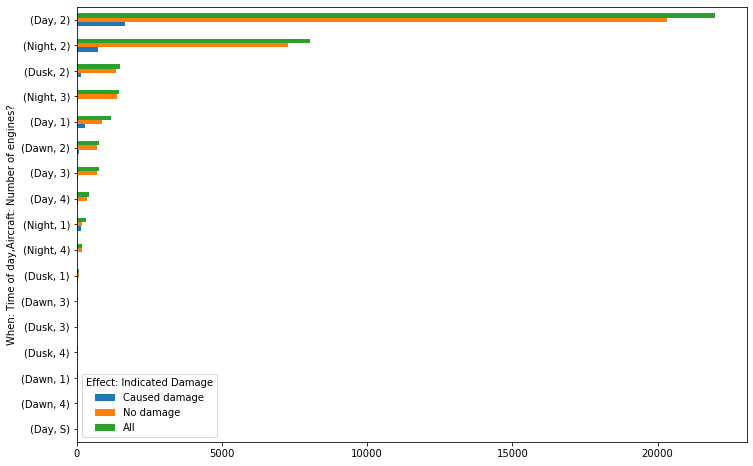

In [ ]:
pd.crosstab([data['When: Time of day'],
             data['Aircraft: Number of engines?']],
             data['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[:-1].plot.barh(figsize=(12, 8));

What shows up as strong correlation might just be a result of frequency wrt. twin-engine aircrafts flying during the day (read: almost all commercial airlines or modern military jets).

## Aircraft: Make/Model &rarr; Effect: Indicated Damage

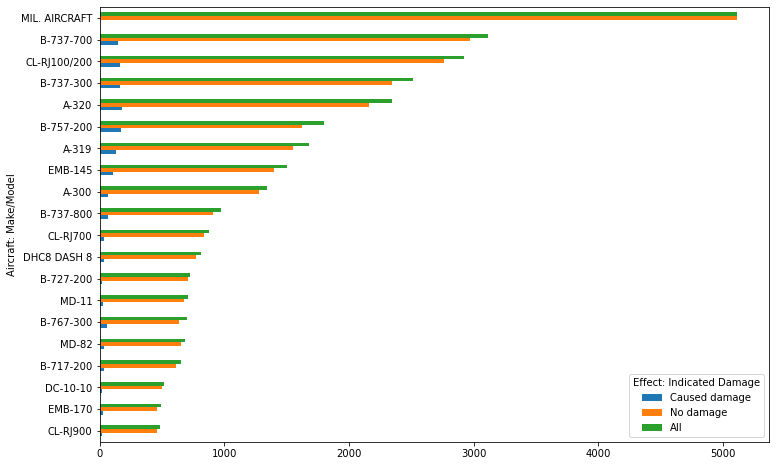

In [ ]:
pd.crosstab(data['Aircraft: Make/Model'],
            data['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[-21:-1].plot.barh(figsize=(12, 8));

Aircraft models favored by (commercial) operators fly more often and therefore report more bird strikes, naturally. Military aircrafts report the majority of bird strikes.

It's difficult to see whether the size of an aircraft, such as the massive Boeing 737 variants as compared to a much smaller model such as the DHC8 DASH 8, has an effect. Type of engine, such as turboprop vs jet engines, which is a distinctive feature among aircraft models, could also influence this figure.

## Speed (IAS) in knots, When: Phase of flight &rarr; Effect: Indicated Damage

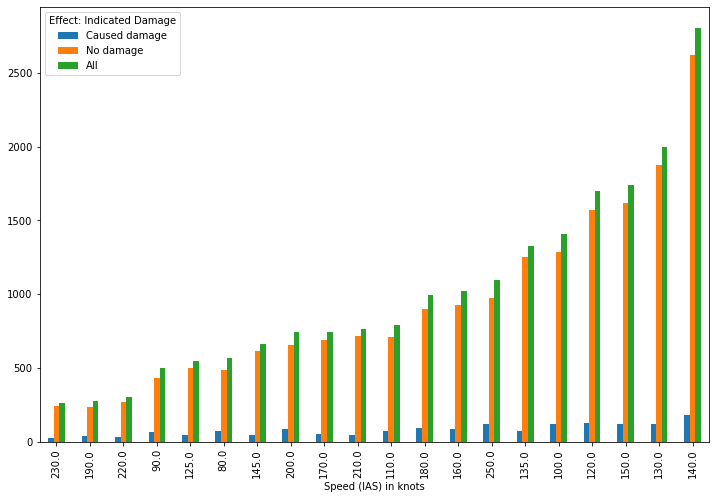

In [ ]:
pd.crosstab(data['Speed (IAS) in knots'],
            data['Effect: Indicated Damage'],
            margins=True).sort_values(by='All', ascending=True)[-21:-1].plot.bar(figsize=(12, 8));

There is a speed interval around 100-180 knots that reports the majority of bird strike reports.

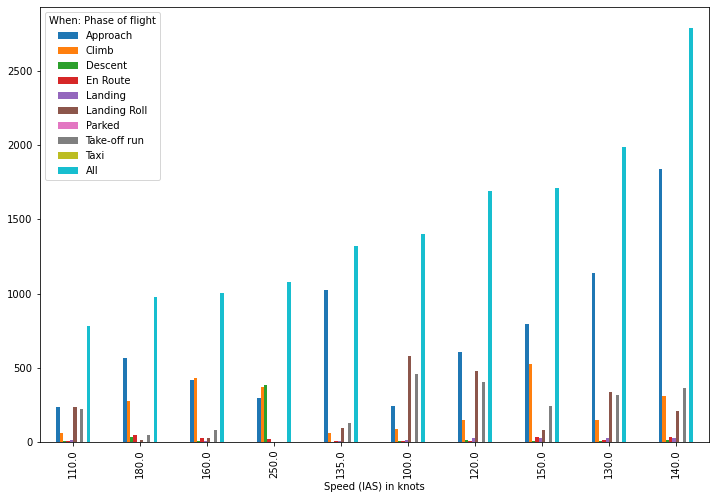

In [ ]:
pd.crosstab(data['Speed (IAS) in knots'],
            data['When: Phase of flight'],
            margins=True).sort_values(by='All', ascending=True)[-11:-1].plot.bar(figsize=(12, 8));

Most bird strike seemingly happen during approach, with a speed (IAS) between 120 and 140 knots.
Climb phase (at slightly higher speeds) and descent (at approx. twice the speed) also show an increase in bird strike reports.

## Seasonal effects

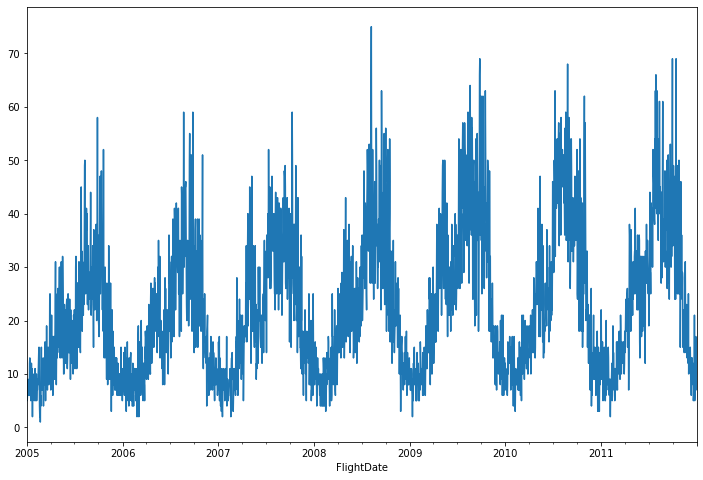

In [ ]:
data.groupby(['FlightDate']).count()['When: Time of day'].plot(figsize=(12,8));

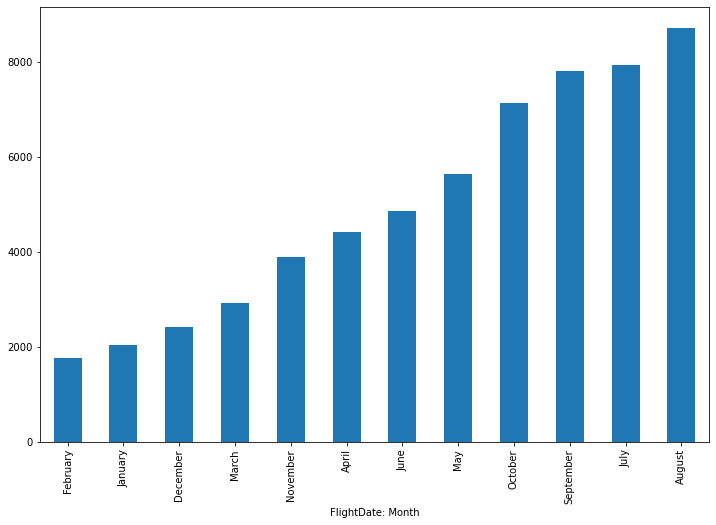

In [ ]:
data['FlightDate: Month'] = data['FlightDate'].dt.strftime('%B') # dependent on locale, use .dt.month elsewhere!
data.groupby(['FlightDate: Month']).count()['FlightDate'].sort_values().plot.bar(figsize=(12,8));

We see a seasonal increase in bird strikes during summer and autumn, from July to October. Most birds probably migrate to the south during the colder seasons (given that the data is from the US, which is in the northern hemisphere), so this is entirely expected.

## When: Time (HHMM) &rarr; Effect: Indicated Damage over Bird Season vs. ~Bird Season

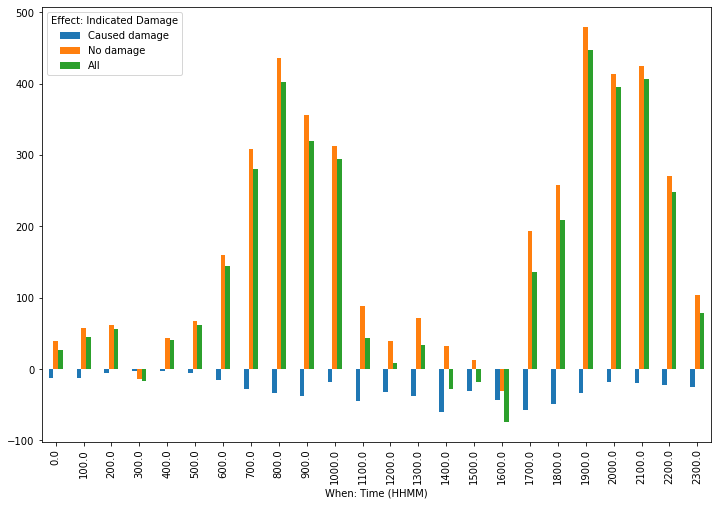

In [ ]:
bird_season = [7, 8, 9, 10]

data_bs = data[data['FlightDate'].dt.month.isin(bird_season)]
data_not_bs = data[~data['FlightDate'].dt.month.isin(bird_season)]

(pd.crosstab(data_bs['When: Time (HHMM)'] // 100 * 100,
             data_bs['Effect: Indicated Damage'],
             margins=True) - pd.crosstab(data_not_bs['When: Time (HHMM)'] // 100 * 100,
                                         data_not_bs['Effect: Indicated Damage'],
                                         margins=True))[:-1].plot.bar(figsize=(12, 8));

Earlier we've shown a figure of bird strikes likelihood distributed over the whole day. Knowing that there is a bird season we can now get a clearer picture of the same correlation. We see a much stronger likelihood of bird strike reports during morning/early morning and during the evening. Surprisingly, perhaps, the risk of bird strikes causing damage to the aircraft is *higher* during the off-season.

## Summary

Once the data had been cleaned up, with feature engineering around time of day and (military) aircrafts, the analysis proved to be much easier. Making proper use of categorical data was essential. Seemingly a roadblock at first, [pd.DataFrame.corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) could be made to operate well on categorical data, via [pd.Categorical()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html) and the [codes Pandas generates automatically](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.codes.html) for each categorical dtype. The resulting heatmap could then be used to guide us towards visualization of strong correlations.

### Features that correlate with increased bird strike reports

* Airport: Name,
* Aircraft: Airline/Operator in combination with Airport: Name,
* Whether Airline/Operator is an air freight carrier or operates air freight hubs,
* Altitude in combination with Wildlife: Size,
* When: Time (HHMM),
* When: Time of day in combination with Aircraft: Number of engines,
* Aircraft: Make/Model,
* Speed (IAS) in knots in combination with When: Phase of flights
* Seasonal effects wrt. bird season